# Extract all fitted params from many dates in OGA butler

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-14
- last update : 2024-01-14
- affiliation : IJCLab/IN2P3/CNRS


## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [3]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [6]:
sys.path.append("../lib")
from libanaspectra import *

In [7]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

#README.md        darksky.dat      filter_r.dat     hardware_g.dat   hardware_y.dat   lens3.dat        total_g.dat      total_y.dat
#README_SOURCE.md detector.dat     filter_u.dat     hardware_i.dat   hardware_z.dat   m1.dat           total_i.dat      total_z.dat
#atmos_10.dat     filter_g.dat     filter_y.dat     hardware_r.dat   lens1.dat        m2.dat           total_r.dat      version_info
#atmos_std.dat    filter_i.dat     filter_z.dat     hardware_u.dat   lens2.dat        m3.dat           total_u.dat
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [8]:
#FILTERWL: precalculated array containing center, boundaries and width of each filter.
#index 0 : minimum wavelength of filter border
#index 1 : minimum wavelength of filter border
#index 2 : center wavelength of filter
#index 3 : filter width


FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL_auxtel = np.array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
                     [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
                     [ 541.4 ,  715.5 ,  628.45,  174.1 ],
                     [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
                     [ 805.6 , 1090.7 ,  948.15,  285.1 ]])


F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2 # cm2  Reff=6.423 m
A_auxtel  = 9636.0 # cm2

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*A*DT/gel/hP)

In [9]:
fdir = get_data_dir()
bandpass_inst = {}
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=WL,sb=ff(WL))

In [10]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(WL,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(WL,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total Rubin-LSST filter throughput")

Text(0.5, 1.0, 'Total Rubin-LSST filter throughput')

In [11]:
#from lsst.summit.utils.utils import checkStackSetup
#checkStackSetup()

In [12]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T100936Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T130352Z


## Config

### Config collection

In [13]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21

my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

### Config Auxtel

In [14]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [15]:
load_config(config_fullpath)

### Config Telescope Throughtput

In [16]:
throughput_fullpath = os.path.join(spectractor.__path__[0],parameters.THROUGHPUT_DIR)
throughput_fullfilename = os.path.join(throughput_fullpath,throughput_filename)

In [17]:
tel_lambdas, tel_thr, tel_errthr = load_transmission(throughput_fullfilename) 

In [18]:
parameters.THROUGHPUT_DIR = throughput_fullpath 
parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = throughput_filename
print(parameters.THROUGHPUT_DIR )
print(parameters.OBS_FULL_INSTRUMENT_TRANSMISSON)

/home/d/dagoret/repos/repos_w_2023_44/Spectractor/lib/python/spectractor/simulation/AuxTelThroughput/
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [19]:
%matplotlib inline
tel = TelescopeTransmission()
tel.plot_transmission()

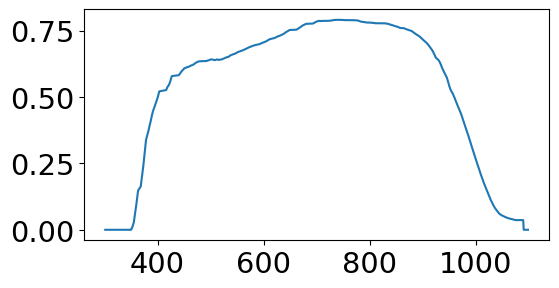

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,tel.transmission(tel_lambdas))

### Config disperser

In [21]:
disp = dispersers.Hologram("holo4_003")

## Load config filename for Auxtel

In [22]:
load_config(config_fullpath)

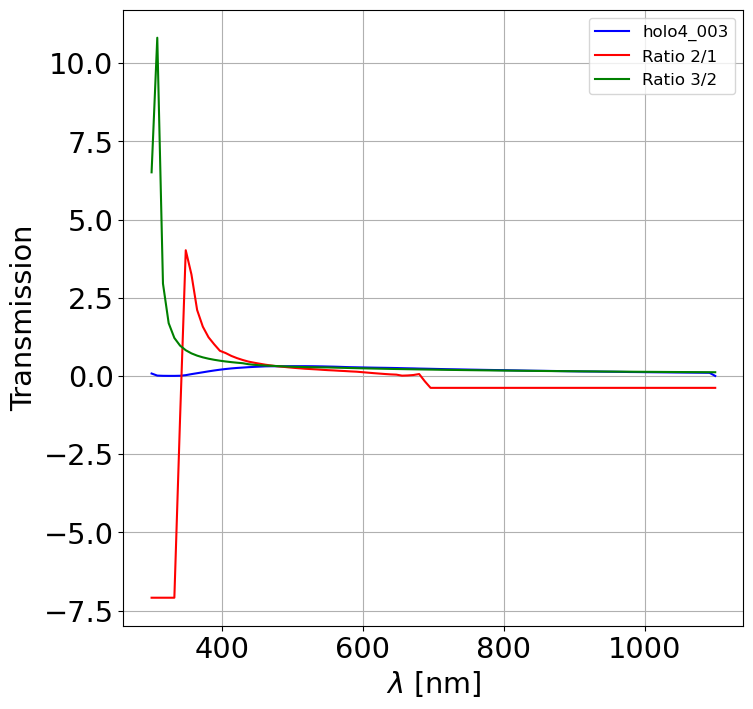

In [23]:
disp.plot_transmission()

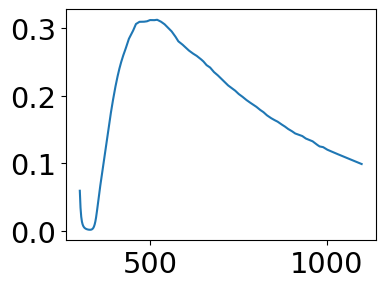

In [24]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,disp.transmission(tel_lambdas))

## Check the presence of the spectra

### select the date of observation in 2022 and 2023

In [25]:
ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
       20230314, 20230315, 20230316, 20230509, 20230510, 20230511,
       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
       20230802, 20230815, 20230817, 20230829, 20230912, 20230913,
       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
       20231108, 20231113, 20231114, 20231115, 20231116, 20231120,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220])

file_out_allfittedparams = "out_allfittedparams.csv"

- Split in 4 parts because too many files open

In [26]:

ALL_DATEOBS = np.array([20220913, 20220914, 20220927, 20220928, 20220929, 20221011,
       20221012, 20221025, 20221026, 20221027, 20221109, 20221110,
       20221123, 20221207, 20221208, 20221209, 20221210, 20221212])
file_out_allfittedparams = "out_allfittedparams_2022_3_3.csv"


#ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
#       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
#       20230314, 20230315, 20230316]) 
#file_out_allfittedparams = "out_allfittedparams_2023_1_4.csv"
                        
#ALL_DATEOBS = np.array([20230509, 20230510, 20230511,
#       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
#       20230802, 20230815, 20230817, 20230829]) 
#file_out_allfittedparams = "out_allfittedparams_2023_2_4.csv"                        
                        
#ALL_DATEOBS = np.array([20230912, 20230913,
#       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
#       20231108, 20231113, 20231114, 20231115, 20231116]) 
#file_out_allfittedparams = "out_allfittedparams_2023_3_4.csv"


#ALL_DATEOBS = np.array([20231120,
#       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
#       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
#       20231219, 20231220])
#file_out_allfittedparams = "out_allfittedparams_2023_4_4.csv"

In [27]:
len(ALL_DATEOBS)

18

## Access to spectra using the butler

In [28]:
all_records = []
for DATEOBS in ALL_DATEOBS:
    where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
    records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
    all_records.append(records)
    print(f">>> {DATEOBS} :  Number of records : ",len(records))
    

>>> 20220913 :  Number of records :  106
>>> 20220914 :  Number of records :  176
>>> 20220927 :  Number of records :  76
>>> 20220928 :  Number of records :  98
>>> 20220929 :  Number of records :  98
>>> 20221011 :  Number of records :  22
>>> 20221012 :  Number of records :  18
>>> 20221025 :  Number of records :  25
>>> 20221026 :  Number of records :  38
>>> 20221027 :  Number of records :  37
>>> 20221109 :  Number of records :  36
>>> 20221110 :  Number of records :  60
>>> 20221123 :  Number of records :  74
>>> 20221207 :  Number of records :  43
>>> 20221208 :  Number of records :  81
>>> 20221209 :  Number of records :  20
>>> 20221210 :  Number of records :  20
>>> 20221212 :  Number of records :  25


In [29]:
len(all_records)

18

## Get params, times, headers and Spectra

In [30]:
all_params_spectrum = []
all_params_spectrogram = []
all_times = []
all_headers = []
#all_spectra = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):
    print(idx,DATEOBS)
    records = all_records[idx]


    params_spectrum = []
    params_spectrogram = []
    times = []
    headers = []
    spectra = []

    for i, r in enumerate(records):
        try:
            times.append(r.day_obs)
            spec =  butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            headers.append(spec.header)
            spectra.append(spec)
            p = butler.get('spectrumLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            params_spectrum.append(p)
            p = butler.get('spectrogramLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            params_spectrogram.append(p)
    #except ValueError:
        except Exception as inst:
            except_type = type(inst)
            except_args = inst.args
            print("catch exception ", inst, "type =",except_type, "args = ",except_args) 
            print("\t >>>>> Skip record ", r.id)
            continue

    all_params_spectrum.append(params_spectrum)
    all_params_spectrogram.append(params_spectrogram)
    all_times.append(times)
    all_headers.append(headers)
    #all_spectra.append(spectra)

0 20220913
************ getObsAtmo imported ************* 
/home/d/dagoret/.local/lib/python3.11/site-packages/getObsAtmo
>>>> _getPackageDir /home/d/dagoret/.local/lib/python3.11/site-packages/getObsAtmo
>>>> getObsSiteDataFrame      altitude   pressure
LSST    2.663  731.50433
CTIO    2.207   774.6052
OHP      0.65  937.22595
PDM    2.8905  710.90637
OMK     4.205  600.17224
OSL       0.0     1013.0


2024-01-16 09:34:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


1 20220914


2024-01-16 09:34:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:34:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2 20220927


2024-01-16 09:35:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:35:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


3 20220928


2024-01-16 09:36:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:36:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


4 20220929


2024-01-16 09:37:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


5 20221011


2024-01-16 09:37:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


6 20221012


2024-01-16 09:37:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


7 20221025


2024-01-16 09:37:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


8 20221026


2024-01-16 09:37:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:37:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


9 20221027


2024-01-16 09:38:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


10 20221109


2024-01-16 09:38:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


11 20221110


2024-01-16 09:38:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:38:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


12 20221123


2024-01-16 09:39:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


13 20221207


2024-01-16 09:39:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


14 20221208


2024-01-16 09:39:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:39:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


15 20221209


2024-01-16 09:40:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


16 20221210


2024-01-16 09:40:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


17 20221212


2024-01-16 09:40:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


## Filtering data

In [31]:
all_filtered_spectra = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):
    records = all_records[idx]
    spectra_filtered = filter_data(butler,my_collection,DATEOBS,records)
    all_filtered_spectra.append(spectra_filtered)
    

2024-01-16 09:40:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:40:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:41:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:42:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:43:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:32  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:33  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:34  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:35  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:36  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:37  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:38  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:39  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:40  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:41  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-16 09:44:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


## Information from atmospheric fits

In [32]:
headers = all_headers[0]

In [33]:
columns_spectrum = ["id"]

for h in headers[0]:
    if "COMMENT" in h or "EXTNAME" in h: continue
    if "LBDAS_T" in h or "PSF_P_T" in h or "AMPLIS_T" in h: continue
    if "UNIT" in h: continue
    if "SIMPLE" in h: continue
    columns_spectrum.append(h)
 
columns_spectrogram_bestfit = []
for key in params_spectrogram[0].labels:
    columns_spectrogram_bestfit.append(key)
    columns_spectrogram_bestfit.append(key+"_err")

columns_spectrum_bestfit = []
for key in params_spectrum[0].labels:
    columns_spectrum_bestfit.append(key)
    columns_spectrum_bestfit.append(key+"_err")

In [34]:
print(columns_spectrum)

['id', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'EXTEND', 'TARGET', 'REDSHIFT', 'GRATING', 'ROTANGLE', 'D2CCD', 'LSHIFT', 'PARANGLE', 'TARGETX', 'TARGETY', 'LBDA_REF', 'PSF_REG', 'TRACE_R', 'MEANFWHM', 'PIXSHIFT', 'CHI2_FIT', 'A2_FIT', 'AM_FIT', 'VERSION', 'REBIN', 'CONFIG', 'DATE-OBS', 'EXPTIME', 'AIRMASS', 'DEC', 'HA', 'OUTTEMP', 'OUTPRESS', 'OUTHUM', 'FILTER', 'CAM_ROT', 'S_X0', 'S_Y0', 'S_XMIN', 'S_XMAX', 'S_YMIN', 'S_YMAX', 'S_NX', 'S_NY', 'S_DEG', 'S_SAT', 'S_ORDER']


In [35]:
print(columns_spectrogram_bestfit)

['A1', 'A1_err', 'A2', 'A2_err', 'A3', 'A3_err', 'VAOD', 'VAOD_err', 'angstrom_exp', 'angstrom_exp_err', 'ozone [db]', 'ozone [db]_err', 'PWV [mm]', 'PWV [mm]_err', 'D_CCD [mm]', 'D_CCD [mm]_err', 'shift_x [pix]', 'shift_x [pix]_err', 'shift_y [pix]', 'shift_y [pix]_err', 'angle [deg]', 'angle [deg]_err', 'B', 'B_err', 'x_c_0_1', 'x_c_0_1_err', 'x_c_1_1', 'x_c_1_1_err', 'x_c_2_1', 'x_c_2_1_err', 'y_c_0_1', 'y_c_0_1_err', 'y_c_1_1', 'y_c_1_1_err', 'y_c_2_1', 'y_c_2_1_err', 'gamma_0_1', 'gamma_0_1_err', 'gamma_1_1', 'gamma_1_1_err', 'gamma_2_1', 'gamma_2_1_err', 'alpha_0_1', 'alpha_0_1_err', 'alpha_1_1', 'alpha_1_1_err', 'alpha_2_1', 'alpha_2_1_err', 'saturation_0_1', 'saturation_0_1_err', 'x_c_0_2', 'x_c_0_2_err', 'x_c_1_2', 'x_c_1_2_err', 'x_c_2_2', 'x_c_2_2_err', 'y_c_0_2', 'y_c_0_2_err', 'y_c_1_2', 'y_c_1_2_err', 'y_c_2_2', 'y_c_2_2_err', 'gamma_0_2', 'gamma_0_2_err', 'gamma_1_2', 'gamma_1_2_err', 'gamma_2_2', 'gamma_2_2_err', 'alpha_0_2', 'alpha_0_2_err', 'alpha_1_2', 'alpha_1_2_err

In [36]:
print(columns_spectrum_bestfit)

['A1', 'A1_err', 'A2', 'A2_err', 'VAOD', 'VAOD_err', 'angstrom_exp', 'angstrom_exp_err', 'ozone [db]', 'ozone [db]_err', 'PWV [mm]', 'PWV [mm]_err', 'reso [pix]', 'reso [pix]_err', 'D_CCD [mm]', 'D_CCD [mm]_err', 'alpha_pix [pix]', 'alpha_pix [pix]_err', 'B', 'B_err']


## Merge dataframes of general paramters and fitted params

In [37]:
all_df = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):
  
    records = all_records[idx]
    headers = all_headers[idx]
    params_spectrogram = all_params_spectrogram[idx]
    params_spectrum = all_params_spectrum[idx]
   
    min_index = 0
    max_index = np.inf

    # General parameters
    df1 = pd.DataFrame(columns=columns_spectrum)
    for k, header in enumerate(headers):
        # if k > 40: break
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for h in header:
            if h in columns_spectrum:
                row[h] = header[h]
        df1.loc[len(df1)] = row


    # fitted parameters in Spectrogram
    df2 = pd.DataFrame(columns=columns_spectrogram_bestfit)
    for k, p in enumerate(params_spectrogram):
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for i, key in enumerate(p.labels):
            row[key] = p.values[i]
            row[key+"_err"] = p.err[i]
        df2.loc[len(df2)] = row

    # fitted parameters in Spectrum
    df3 = pd.DataFrame(columns=columns_spectrum_bestfit)
    for k, p in enumerate(params_spectrum):
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for i, key in enumerate(p.labels):
            row[key] = p.values[i]
            row[key+"_err"] = p.err[i]
        df3.loc[len(df3)] = row

    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df = pd.merge(df, df3, left_index=True, right_index=True)
    df.set_index('DATE-OBS', inplace=True)
    #df.index = pd.to_datetime(df.index, format="ISO8601") #['DATE-OBS'])
    df.index = pd.to_datetime(df.index) #['DATE-OBS'])
    df.sort_index(inplace=True)

    all_df.append(df)
            

In [38]:
all_df[0].head()

,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,...,PWV [mm]_y,PWV [mm]_err_y,reso [pix],reso [pix]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
DATE-OBS,,,,,,,,,,,,,,,,,,,,,
2022-09-14 04:31:31.195495487+00:00,2022091300503,-64,2,1066,3,True,HD200654,-0.000149,holo4_003,0.175332,...,2.008475,0.104363,1.768067,0.062091,187.483747,0.011941,0.049835,0.0,0.0,0.0
2022-09-14 04:32:14.089495329+00:00,2022091300504,-64,2,1067,3,True,HD200654,-0.000149,holo4_003,0.172535,...,1.181479,0.068938,1.725214,0.055256,187.225296,0.015379,0.037056,0.0,0.0,0.0
2022-09-14 04:35:44.431991552+00:00,2022091300510,-64,2,1066,3,True,HD167060,0.000051,holo4_003,0.168839,...,0.000000,0.028134,2.445568,0.067382,186.792648,0.007473,1.072447,0.0,0.0,0.0
2022-09-14 04:36:27.276506616+00:00,2022091300511,-64,2,1066,3,True,HD167060,0.000051,holo4_003,0.197714,...,0.000000,0.000000,0.108965,0.000000,186.781975,0.000000,1.380830,0.0,0.0,0.0
2022-09-14 04:40:23.711501898+00:00,2022091300517,-64,2,1067,3,True,HD14943,0.000016,holo4_003,0.191865,...,4.937670,0.061540,1.015273,0.020744,186.979412,0.003605,1.052417,0.0,0.0,0.0


In [39]:
all_df[1].head()

,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,...,PWV [mm]_y,PWV [mm]_err_y,reso [pix],reso [pix]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
DATE-OBS,,,,,,,,,,,,,,,,,,,,,
2022-09-14 23:37:54.046004493+00:00,2022091400138,-64,2,1066,3,True,HD185975,-0.000065,holo4_003,0.155042,...,1.062133,0.059003,1.715913,0.037021,186.916449,0.008328,1.097895,0.0,0.0,0.0
2022-09-14 23:38:36.902491264+00:00,2022091400139,-64,2,1067,3,True,HD185975,-0.000065,holo4_003,0.155145,...,0.829199,0.060440,1.778331,0.034272,186.783652,0.011039,1.053803,0.0,0.0,0.0
2022-09-14 23:42:20.878006539+00:00,2022091400145,-64,2,1067,3,True,HD200654,-0.000149,holo4_003,0.173380,...,1.455718,0.032174,1.573937,0.044931,186.989685,0.007223,1.077258,0.0,0.0,0.0
2022-09-14 23:43:03.808501966+00:00,2022091400146,-64,2,1067,3,True,HD200654,-0.000149,holo4_003,0.178554,...,1.308203,0.032556,1.292155,0.045103,187.000644,0.006559,1.095082,0.0,0.0,0.0
2022-09-14 23:46:46.344496310+00:00,2022091400152,-64,2,1067,3,True,HD167060,0.000051,holo4_003,0.178628,...,1.611144,0.035938,2.182531,0.040992,186.909176,0.006728,1.042241,0.0,0.0,0.0


In [40]:
df =  pd.concat(all_df)

## Write csv file

In [41]:
df.to_csv(file_out_allfittedparams) 

In [42]:
# convert pandas to numpy rec array
rec = df.to_records()

In [43]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

923
895
864
765
755
340


In [44]:
stars = np.unique(rec["TARGET"])
stars

array(['HD009051', 'HD031128', 'HD074000', 'HD14943', 'HD167060',
       'HD185975', 'HD200654', 'HD205905', 'HD2811', 'HD37962', 'HD38666',
       'HD38949', 'HD42525', 'HD60753'], dtype=object)

In [45]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

In [46]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.1,1.9]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]

## Plot fitted parameters

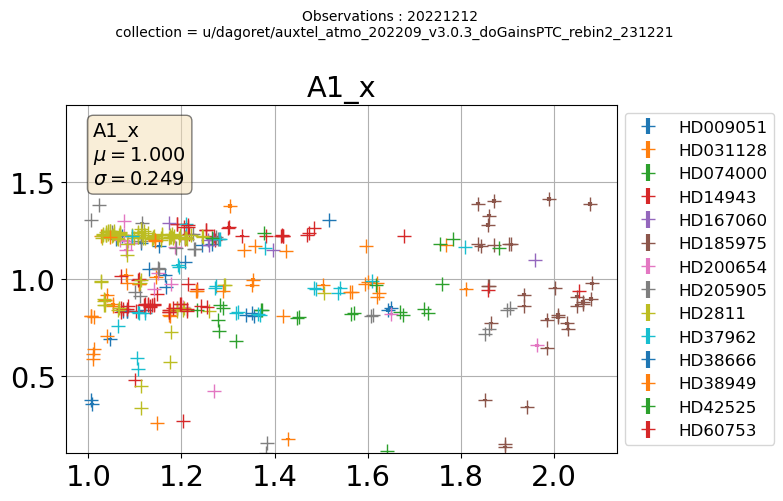

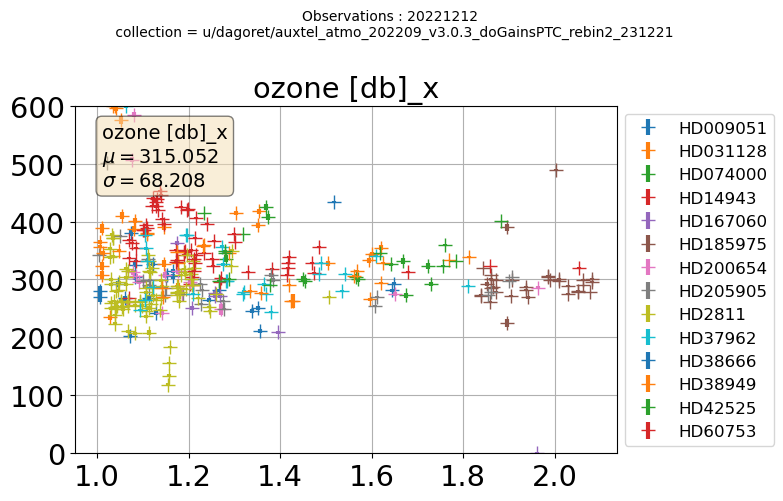

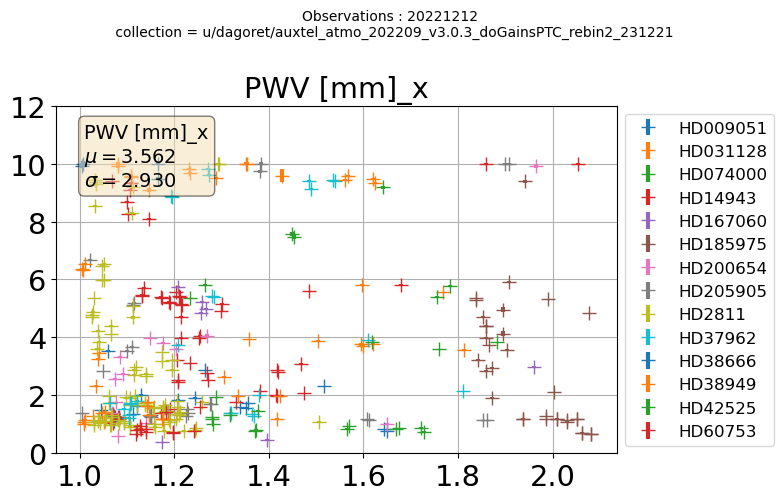

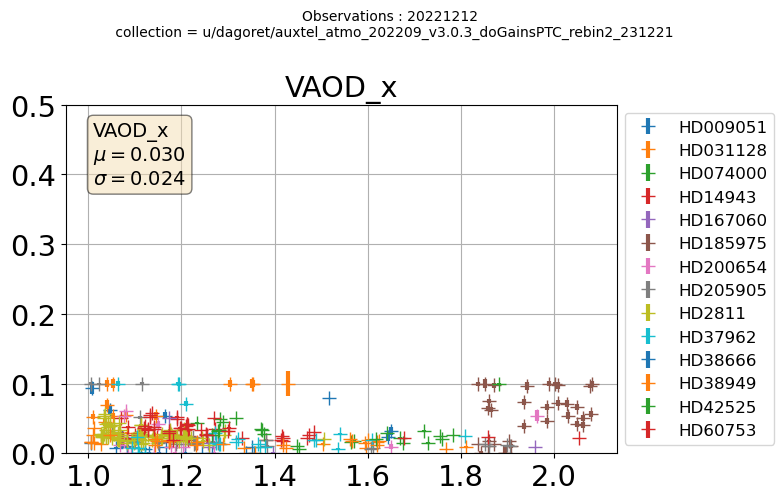

In [47]:
#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_0_2" ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))



    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=10,lw=3 ,label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3 )
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()


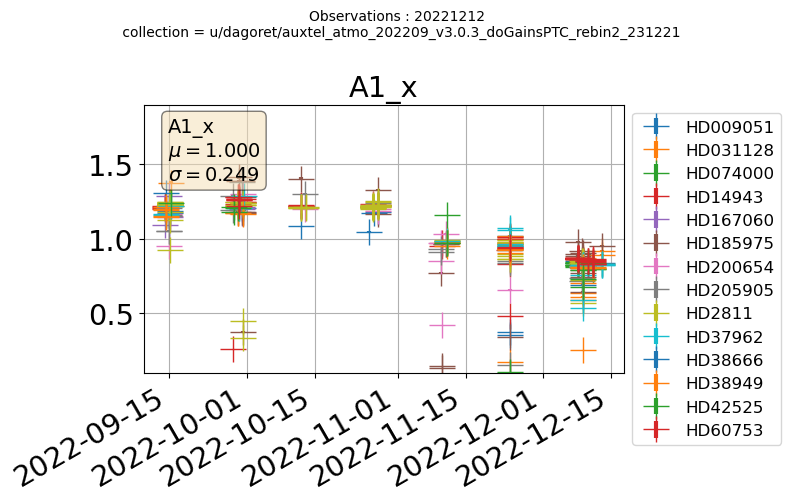

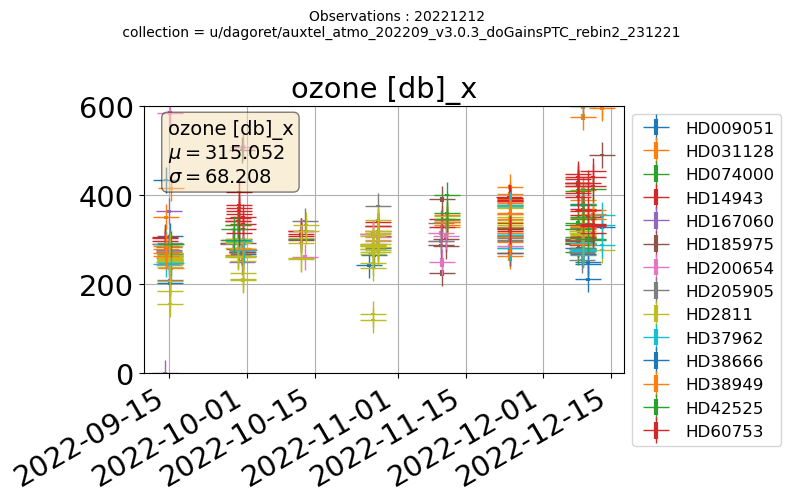

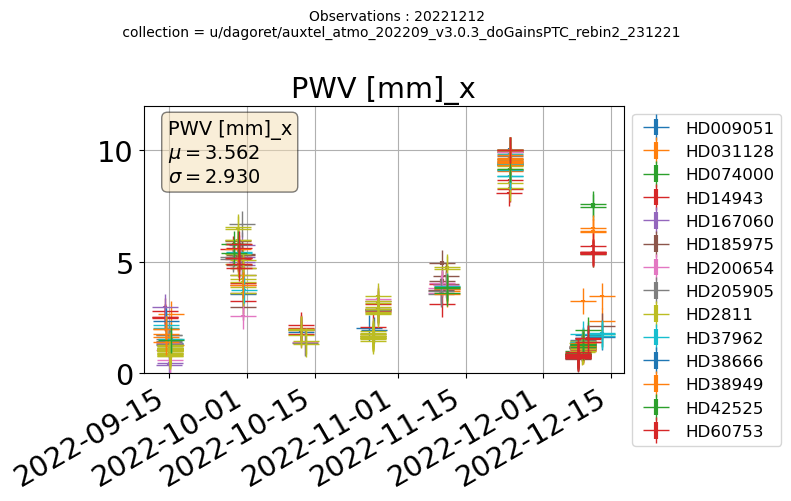

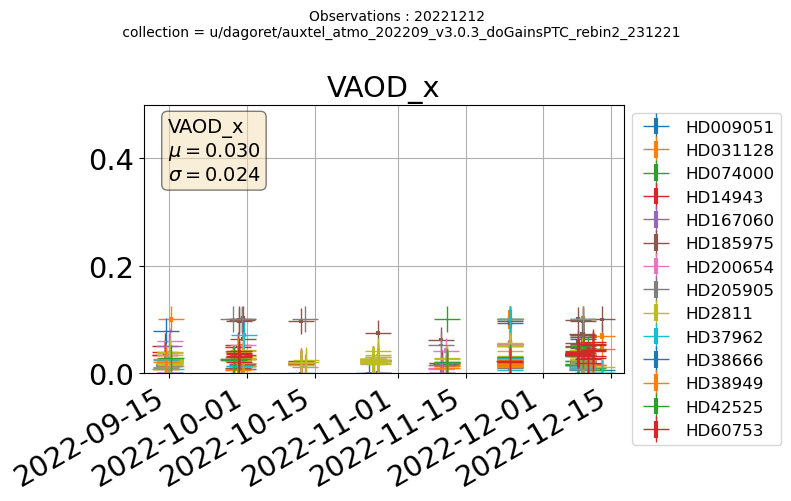

In [48]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(8,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()